In [24]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape,
                                     Bidirectional, LSTM, Dense, Dropout)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, precision_score

In [3]:
def load_mel_spectrograms_from_h5(file_path):
    try:
        with h5py.File(file_path, "r") as h5_file:
            print(h5_file.keys())
            X = h5_file['X']
            y = h5_file['y']
            return np.array(X), np.array(y)
    except:
        print("Lỗi trong quá trình load dữ liệu từ file!")

In [4]:
file_path = "/content/drive/MyDrive/ML_datasets/processed_data.h5"

In [11]:
X, y = load_mel_spectrograms_from_h5(file_path)
print(X.shape, y.shape)

<KeysViewHDF5 ['X', 'y']>
(7000, 16640) (7000,)


In [13]:
X = X.reshape(-1, 128, 130)

In [15]:
X = X[..., np.newaxis]

In [16]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = to_categorical(y_encoded)

In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [32]:
def build_crnn_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Reshape for RNN input: (batch, time, features)
    shape = x.shape
    x = Reshape((shape[1], shape[2]*shape[3]))(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)

    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_crnn_model(input_shape=(128, 130, 1), num_classes=y.shape[1])

In [33]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.4018 - loss: 1.5676 - val_accuracy: 0.1471 - val_loss: 2.7036
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7079 - loss: 0.8915 - val_accuracy: 0.2000 - val_loss: 2.7270
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7762 - loss: 0.6832 - val_accuracy: 0.3371 - val_loss: 2.1729
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8318 - loss: 0.5431 - val_accuracy: 0.6329 - val_loss: 0.9661
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8651 - loss: 0.4341 - val_accuracy: 0.8843 - val_loss: 0.3940
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8909 - loss: 0.3780 - val_accuracy: 0.8857 - val_loss: 0.3468
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9073 - loss: 0.3081 - val_accuracy: 0.9014 - val_loss: 0.3014
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9222 - loss: 0.2740 - val_accu

In [35]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9252 - loss: 0.2089
Test Accuracy: 0.9257143139839172


In [36]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [37]:
print(f"Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.3f}")
print(
    f"Precision: {precision_score(y_true_classes, y_pred_classes, average='macro'):.3f}")
print(f"Recall: {recall_score(y_true_classes, y_pred_classes, average='macro'):.3f}")
print(f"F1: {f1_score(y_true_classes, y_pred_classes, average='macro'):.3f}")

Accuracy: 0.926
Precision: 0.929
Recall: 0.926
F1: 0.926


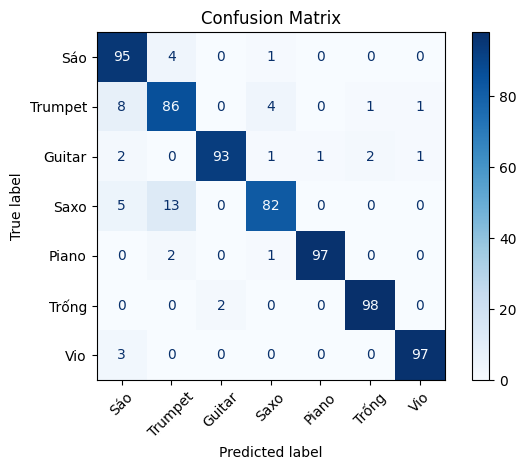

In [38]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels_name = ["Sáo", "Trumpet", "Guitar", "Saxo", "Piano", "Trống", "Vio"]

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_name).plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ML_datasets/cm_crnn", dpi=300)
plt.show()